In [54]:
import polars
mag = polars.read_csv("mag.tbl", separator="\t")

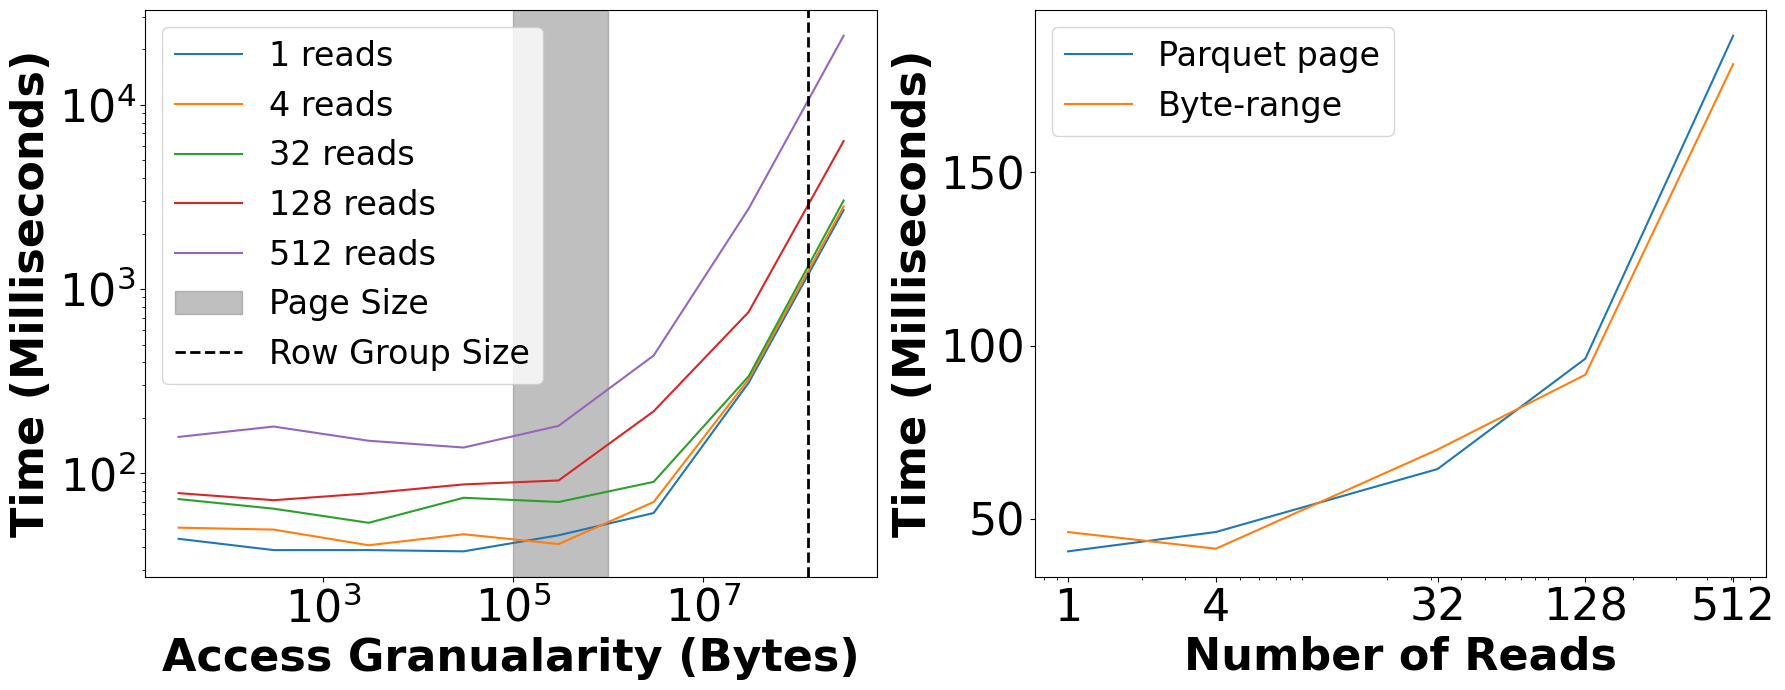

In [55]:
from matplotlib import pyplot as plt
plt.style.use('default')

# make two axs
fig, axes = plt.subplots(1,2, figsize=(18, 7))

ax = axes[0]

mag = polars.read_csv("mag.tbl", separator="\t")
for i in ["1", "4", "32", "128", "512"]:
    ax.plot(mag["MAG"], mag[i], label=f"{i} reads")


#log scale
ax.set_xscale("log")
ax.set_yscale("log")
# tilt x-axis labels
ax.set_xlabel("Access Granualarity (Bytes)", fontsize=32, fontweight='bold')
# bold axes labels and make font size 18
ax.set_ylabel("Time (Milliseconds)", fontsize=32, fontweight='bold')
# make x tick font size 18
ax.tick_params(axis='both', which='major', labelsize=32)


# make a shaded box with x from 1e5 to 1e6 and entire y
ax.axvspan(1e5, 1e6, color='gray', alpha=0.5, label="Page Size")

# draw a horizontal line at 1e8
ax.axvline(1.28e8, color='black', linestyle='--', label="Row Group Size", linewidth=2)

ax.legend(fontsize=24, loc="upper left")

parquet_times = [40.6389614, 46.2217536, 64.3848968, 96.2331838, 189.3825542]
raw_times = [46.2,41.4,70,91.6,181.2]
x_labels = [1, 4, 32, 128, 512]

ax = axes[1]
ax.plot(x_labels, parquet_times, label="Parquet page")
ax.plot(x_labels, raw_times, label="Byte-range")
ax.set_xscale("log")
ax.set_xticks(x_labels)
ax.set_xticklabels(x_labels, fontsize=32)
ax.set_xlabel("Number of Reads", fontsize=32, fontweight='bold')
ax.set_ylabel("Time (Milliseconds)", fontsize=32, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=32)
ax.legend(fontsize=24, loc="upper left")

plt.tight_layout()
plt.savefig("mag.pdf")


In [109]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('default')
import matplotlib.ticker as ticker

def plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, title = None, title_adj = -0.2, label = None, label2 = None, color = None, color2 = None, legend = True, linewidth = None):

    cross_over_one = lambda t: (onetime_indexing_cost + storage_overhead_cost_per_month * t) / (cpq2 - cpq1)
    cross_over_two = lambda t: (indexing_cost_per_month * t - onetime_indexing_cost- storage_overhead_cost_per_month * t) / cpq1 
    # cross_over_three = lambda t: indexing_cost_per_month * t / cpq2

    inflection_x = cpq2 * onetime_indexing_cost / (cpq2 * indexing_cost_per_month - cpq2 * storage_overhead_cost_per_month - cpq1 * indexing_cost_per_month)
    inflection_y = cross_over_one(inflection_x)

    ax.grid(which='both', axis='both', linestyle='--', alpha=0.7)
    
    # Ensure only major ticks are shown
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=5))
    # ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=10))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=5))
    # ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=10))
    
    # Customize grid
    ax.grid(which='major', color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.1, alpha=0.2)
    
    x_axis_before_inflection = np.arange(0, inflection_x, 0.01)
    x_axis = np.arange(inflection_x, 40, 0.001)
    y1 = [cross_over_one(i) for i in x_axis]
    y2 = [cross_over_two(i) for i in x_axis]
    print(cross_over_one(10))

    # draw a straight line from 0,0 to inflection_x, inflection_y

    ax.plot([0, inflection_x], [0, inflection_y], color='black', linestyle='-')

    ax.loglog(x_axis, y1,label = label2, color = color, linewidth = linewidth)

    ax.loglog(x_axis, y2, label=label, color = color2, linewidth = linewidth)
    ax.set_xlabel("Months", fontsize=32, fontweight='bold')
    ax.set_ylabel("Total Normalized Queries", fontsize=32, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=32)

    # ax.text(0.05, 300000, "Copy data", fontsize=32)
    # ax.text(1, 4000, "Rottnest", fontsize=32)
    # ax.text(0.5, 40, "Brute force", fontsize=32)
    ax.set_yscale("log")
    ax.set_xscale("log")
    if legend and (label is not None or label2 is not None):
        ax.legend(fontsize=24, loc="upper right")

    ax.set_xlim(0.01, 40)
    ax.set_ylim(30, 10000000)
    if title is not None:
        ax.text(title_adj, 1, title, transform=ax.transAxes, fontsize=32, fontweight='bold')



0.07326077632625998
0.028228506193430494


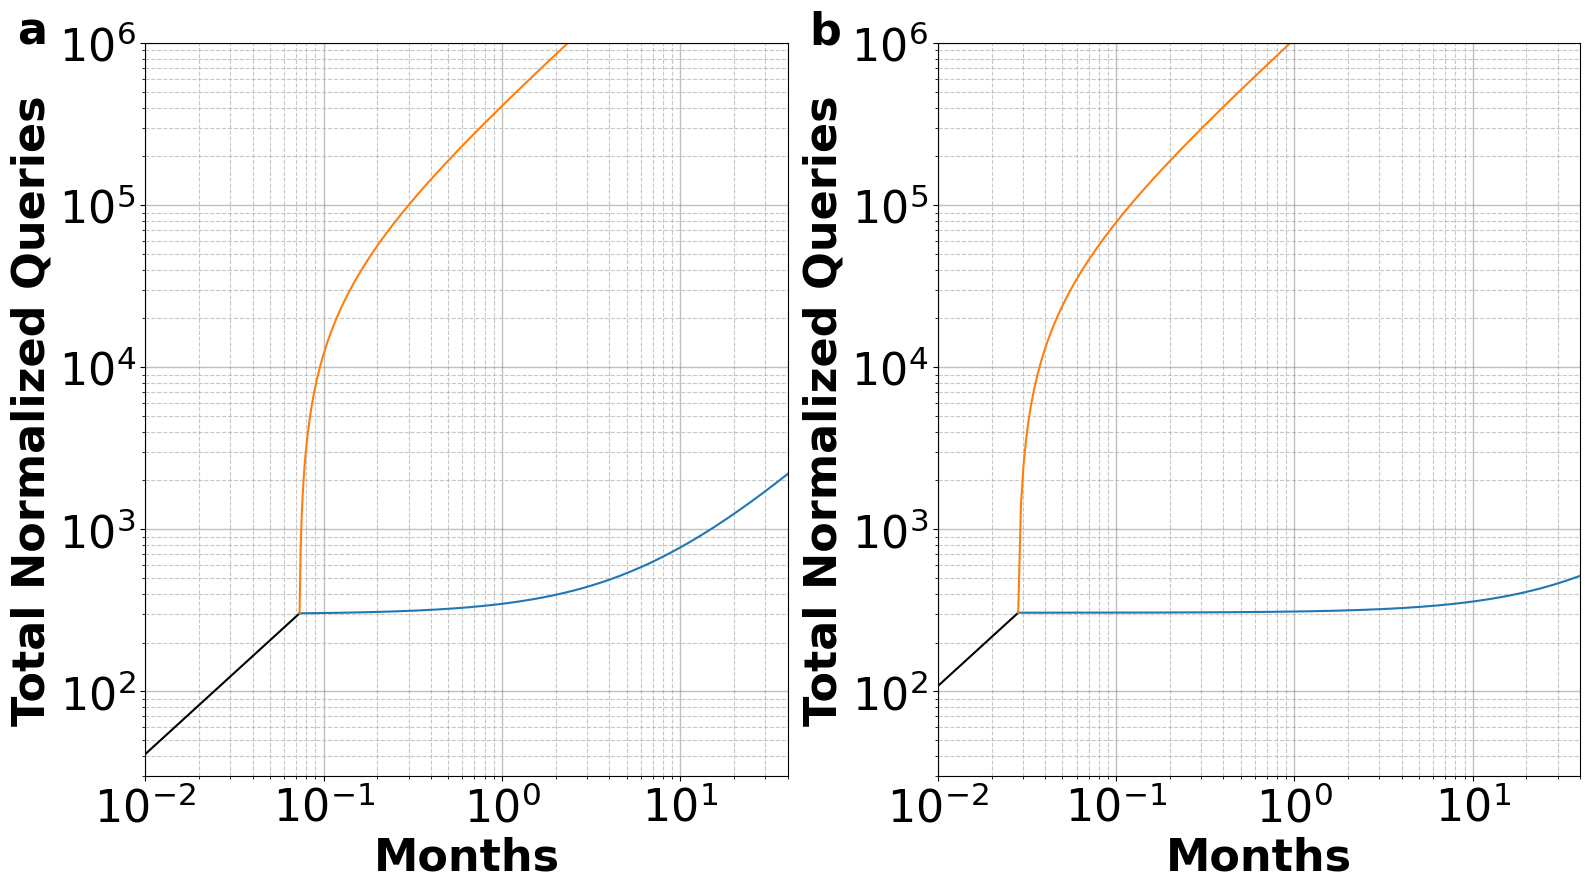

In [97]:
fig, axs = plt.subplots(1,2, figsize=(16, 9))

ax = axs[0]

indexing_cost_per_month = 641.1
onetime_indexing_cost = 46
storage_overhead_cost_per_month = 7.25
cpq1 = 0.00144
cpq2 = 0.155

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, "a")

ax = axs[1]

indexing_cost_per_month = 519.8
onetime_indexing_cost = 14.52
storage_overhead_cost_per_month = 0.25
cpq1 = 0.000478 
cpq2 = 0.048

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, "b")

plt.subplots_adjust(wspace=1)
plt.tight_layout()
plt.savefig("exact_phases.pdf")

771.685334722584
1225.18885126335
850.6819813352477
358.14990951559275
992.3193468288371
386.8181818181818
194.8439620028719
571.6186252719425
285.5701605615227


/tmp/ipykernel_13410/4218840844.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


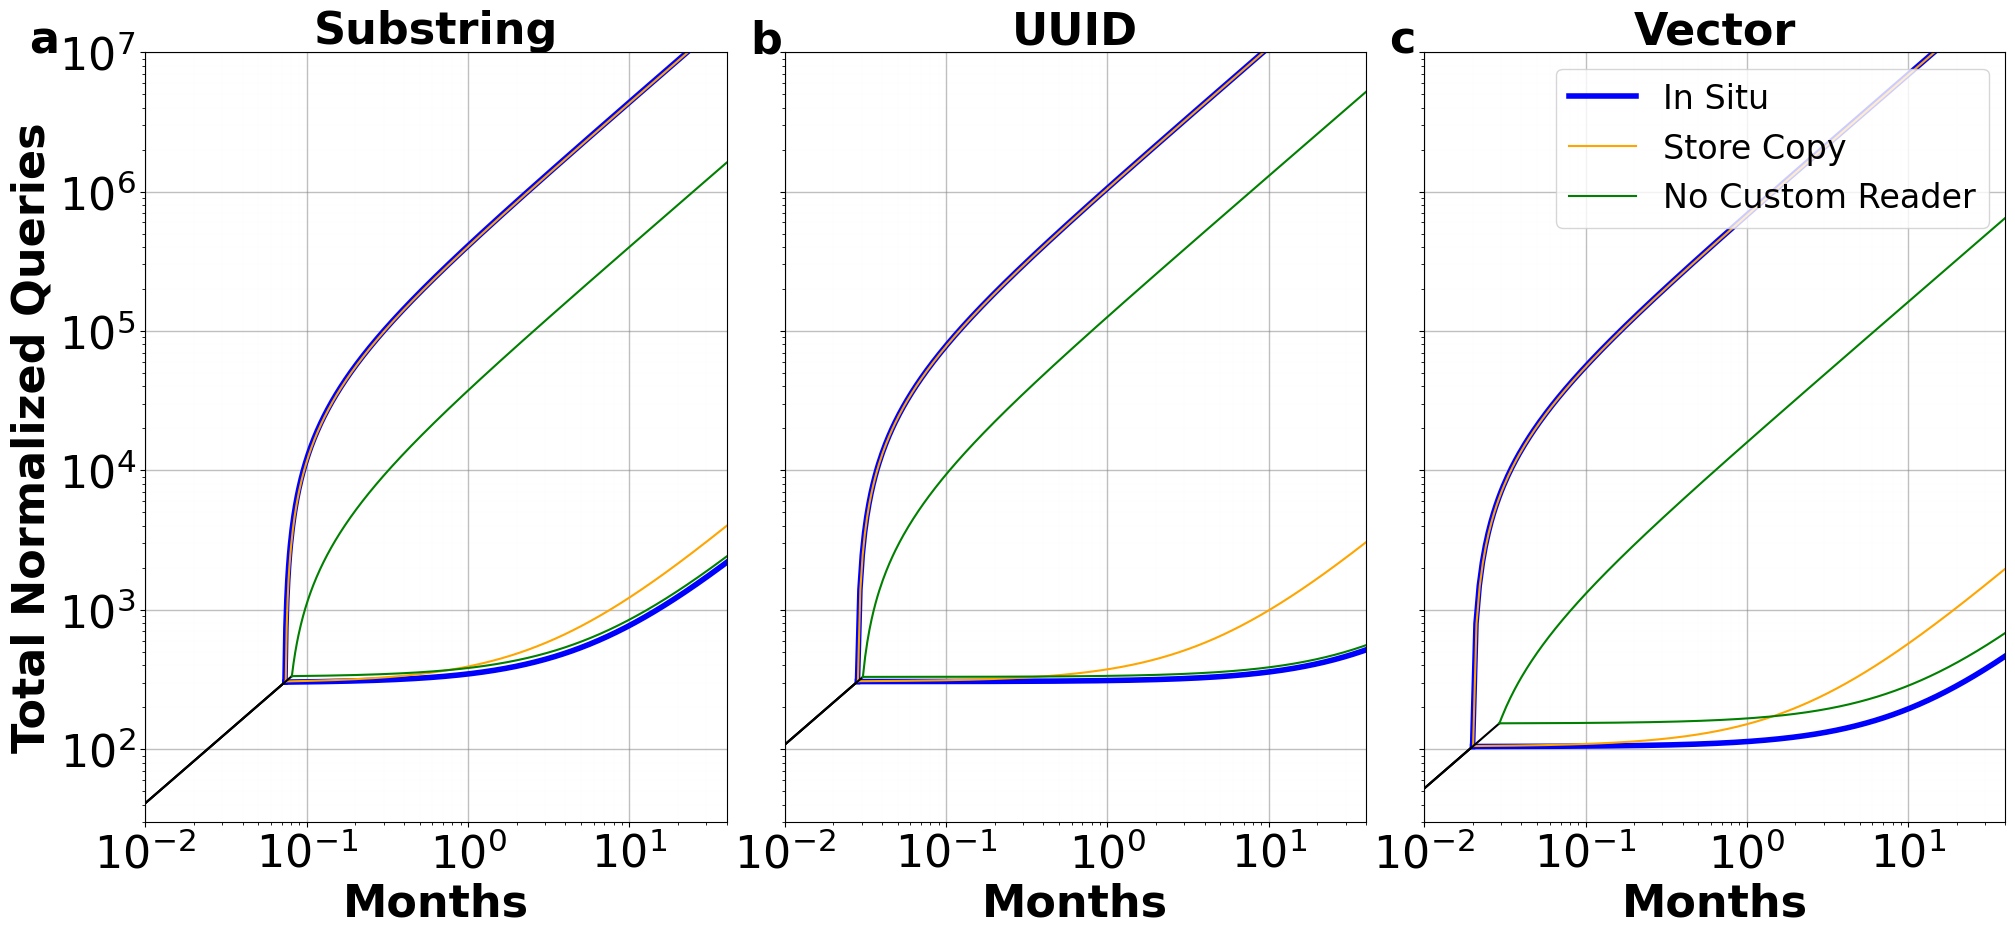

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(24, 10), gridspec_kw={'wspace': 0.1})

# First subplot (left)
ax = axs[0]
indexing_cost_per_month = 641.1
onetime_indexing_cost = 46
storage_overhead_cost_per_month = 7.25
cpq1 = 0.00144
cpq2 = 0.155

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, title = 'a', label2='In Situ', color='blue', color2='blue', legend = False, linewidth = 4)

indexing_cost_per_month = 641.1
onetime_indexing_cost = 46
storage_overhead_cost_per_month = 14.214
cpq1 = 0.00144
cpq2 = 0.155

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label2='Store Copy', color='orange', color2='orange', legend = False)

indexing_cost_per_month = 641.1
onetime_indexing_cost = 46
storage_overhead_cost_per_month = 7.25
cpq1 = 0.0157
cpq2 = 0.155

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label='No Custom Reader', color='green', color2='green', legend = False)

ax.set_title('Substring', fontsize=32, fontweight='bold')

# Second subplot (center)
ax = axs[1]
indexing_cost_per_month = 519.8
onetime_indexing_cost = 14.52
storage_overhead_cost_per_month = 0.25
cpq1 = 0.000478 
cpq2 = 0.048

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, title = 'b', title_adj=-0.06, label2='In Situ', color='blue', color2='blue', legend = False,  linewidth = 4)

indexing_cost_per_month = 519.8
onetime_indexing_cost = 14.52
storage_overhead_cost_per_month = 3.2637
cpq1 = 0.000478 
cpq2 = 0.048

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label2='Store Copy', color='orange', color2='orange', legend = False)

indexing_cost_per_month = 519.8
onetime_indexing_cost = 14.52
storage_overhead_cost_per_month = 0.25
cpq1 = 0.004
cpq2 = 0.048

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label='No Custom Reader', color='green', color2='green', legend = False)

# Remove y-axis label and ticks for the center subplot
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('UUID', fontsize=32, fontweight='bold')


# Third subplot (right)
ax = axs[2]
indexing_cost_per_month = 443.155
onetime_indexing_cost = 8.764444444
storage_overhead_cost_per_month = 0.759
cpq1 = 0.0006388888889
cpq2 = 0.084575

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, title = 'c', title_adj=-0.06, label2='In Situ', color='blue', color2='blue', linewidth = 4)

indexing_cost_per_month = 443.155
onetime_indexing_cost = 8.764444444
storage_overhead_cost_per_month = 3.9215
cpq1 = 0.0006388888889
cpq2 = 0.084575

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label2='Store Copy', color='orange', color2='orange')

indexing_cost_per_month = 443.155
onetime_indexing_cost = 8.764444444
storage_overhead_cost_per_month = 0.759
cpq1 = 0.02730555556
cpq2 = 0.084575

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label='No Custom Reader', color='green', color2='green')

# Remove y-axis label and ticks for the right subplot
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('Vector', fontsize=32, fontweight='bold')


plt.tight_layout()
plt.savefig("insitu.pdf", bbox_inches='tight', pad_inches=0.5)
# put some text on the upper left that says "Copy data"

0.01981280957760906
0.01982631303952733
0.019962366970256044
0.021433173735428593
0.08142986409908871
0.01992826117037345
0.019931361001756062
0.01996241243771325
0.020278332327748973
0.02409089383858623
0.0001996241243771325
0.001996241243771325
0.01996241243771325
0.19962412437713248
1.9962412437713248


/tmp/ipykernel_13410/4187823694.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


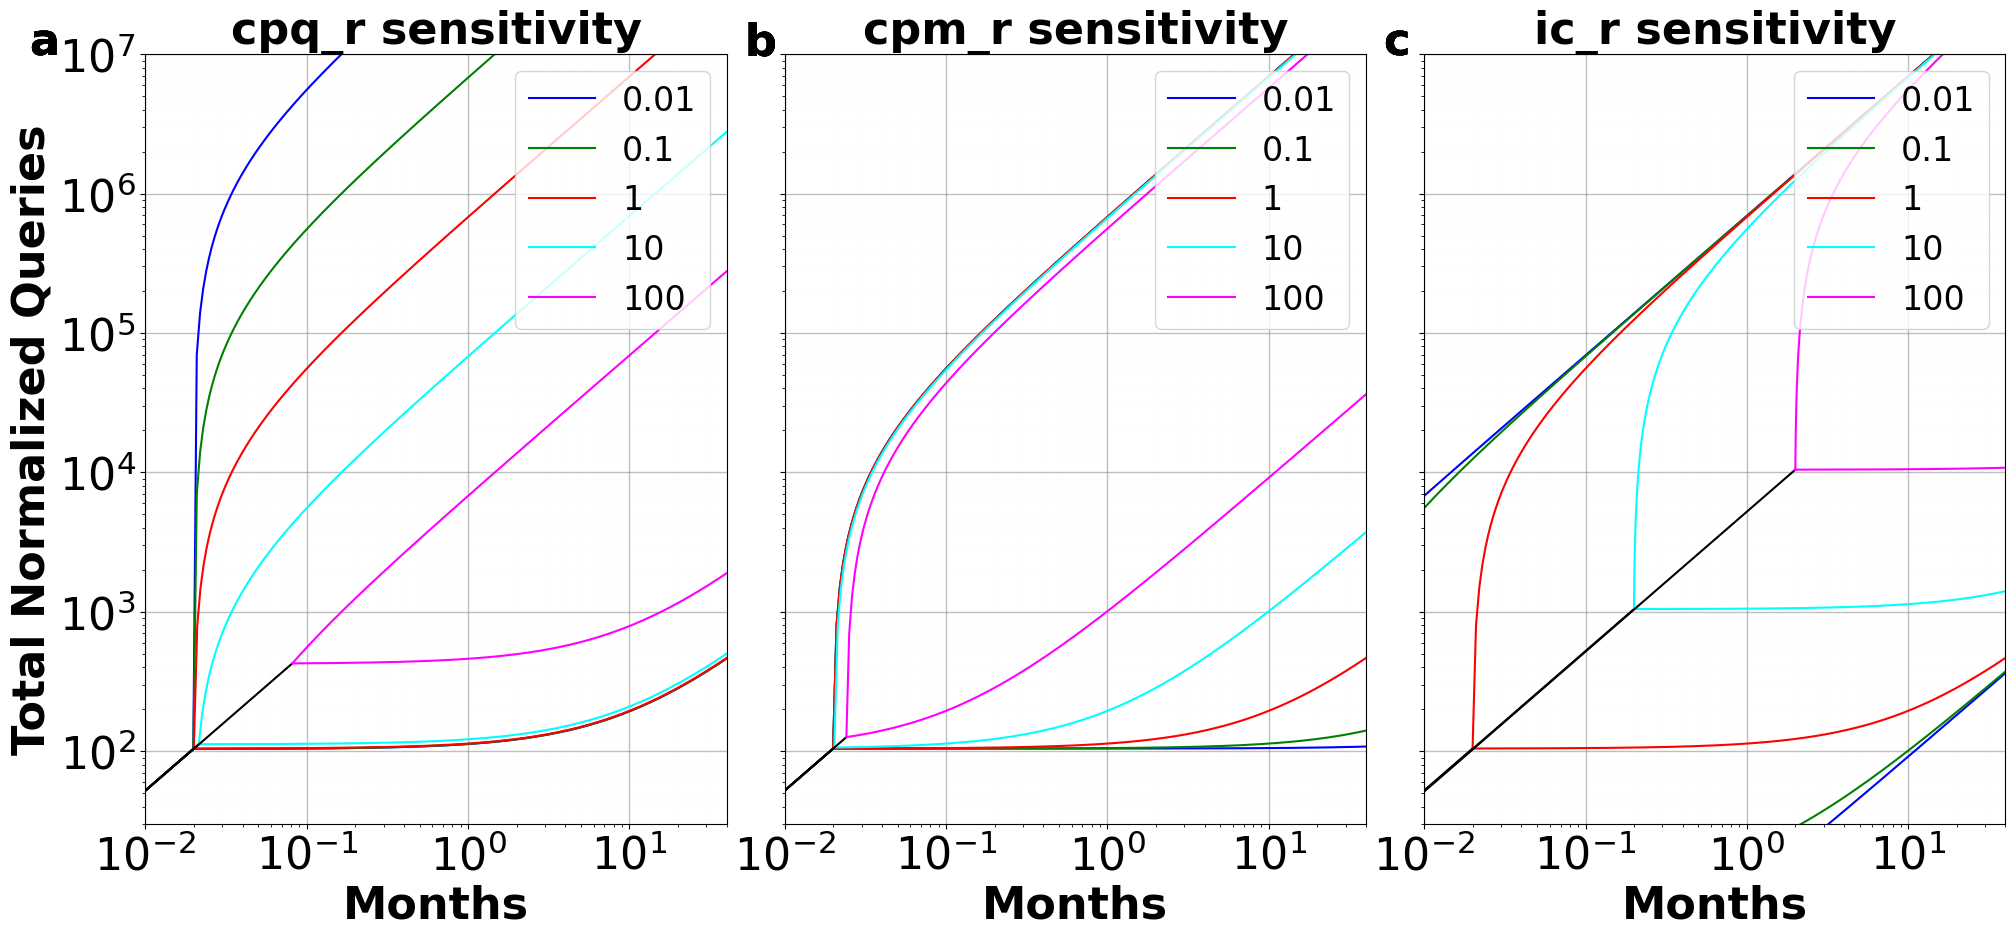

In [107]:
fig, axs = plt.subplots(1, 3, figsize=(24, 10), gridspec_kw={'wspace': 0.1})

# Third subplot (right)
ax = axs[0]

colors = ['blue',
'green',
'red',
'cyan',
'magenta',
'yellow',
'black',
'white']

for i, c in zip([0.01, 0.1, 1, 10, 100], colors):
    indexing_cost_per_month = 443.155
    onetime_indexing_cost = 8.764444444
    storage_overhead_cost_per_month = 0.759
    cpq1 = 0.0006388888889 * i
    cpq2 = 0.084575

    plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, 'a', title_adj=-0.2, label2=i, color=c, color2=c)

ax.set_title('cpq_r sensitivity', fontsize=32, fontweight='bold')

ax = axs[1]

for i, c in zip([0.01, 0.1, 1, 10, 100], colors):
    indexing_cost_per_month = 443.155
    onetime_indexing_cost = 8.764444444
    storage_overhead_cost_per_month = 0.76 * i
    cpq1 = 0.0006388888889 
    cpq2 = 0.084575

    plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, 'b', title_adj=-0.07, label2=i, color=c, color2=c)

ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('cpm_r sensitivity', fontsize=32, fontweight='bold')

ax = axs[2]

for i, c in zip([0.01, 0.1, 1, 10, 100], colors):
    indexing_cost_per_month = 443.155
    onetime_indexing_cost = 8.764444444 * i
    storage_overhead_cost_per_month = 0.76
    cpq1 = 0.0006388888889 
    cpq2 = 0.084575

    plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, 'c', title_adj=-0.07, label2=i, color=c, color2=c)

# Remove y-axis label and ticks for the right subplot
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('ic_r sensitivity', fontsize=32, fontweight='bold')


plt.tight_layout()
plt.savefig("ablation.pdf", bbox_inches='tight', pad_inches=0.5)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(14, 10))



indexing_cost_per_month = 443.155
onetime_indexing_cost = 8.764444444
storage_overhead_cost_per_month = 0.759
cpq1 = 0.0005805555556
cpq2 = 0.084575

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label='Recall = 0.87')

indexing_cost_per_month = 443.155
onetime_indexing_cost = 8.764444444
storage_overhead_cost_per_month = 0.759
cpq1 = 0.0006388888889
cpq2 = 0.084575

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label='Recall = 0.92')

indexing_cost_per_month = 443.155
onetime_indexing_cost = 8.764444444
storage_overhead_cost_per_month = 0.759
cpq1 = 0.0007805555556
cpq2 = 0.084575

plot_chart(ax, indexing_cost_per_month, onetime_indexing_cost, storage_overhead_cost_per_month, cpq1, cpq2, None, label='Recall = 0.97')

# plt.legend()
plt.subplots_adjust(wspace=1)
plt.tight_layout()
plt.savefig("vector_phases.pdf")

# put some text on the upper left that says "Copy data"

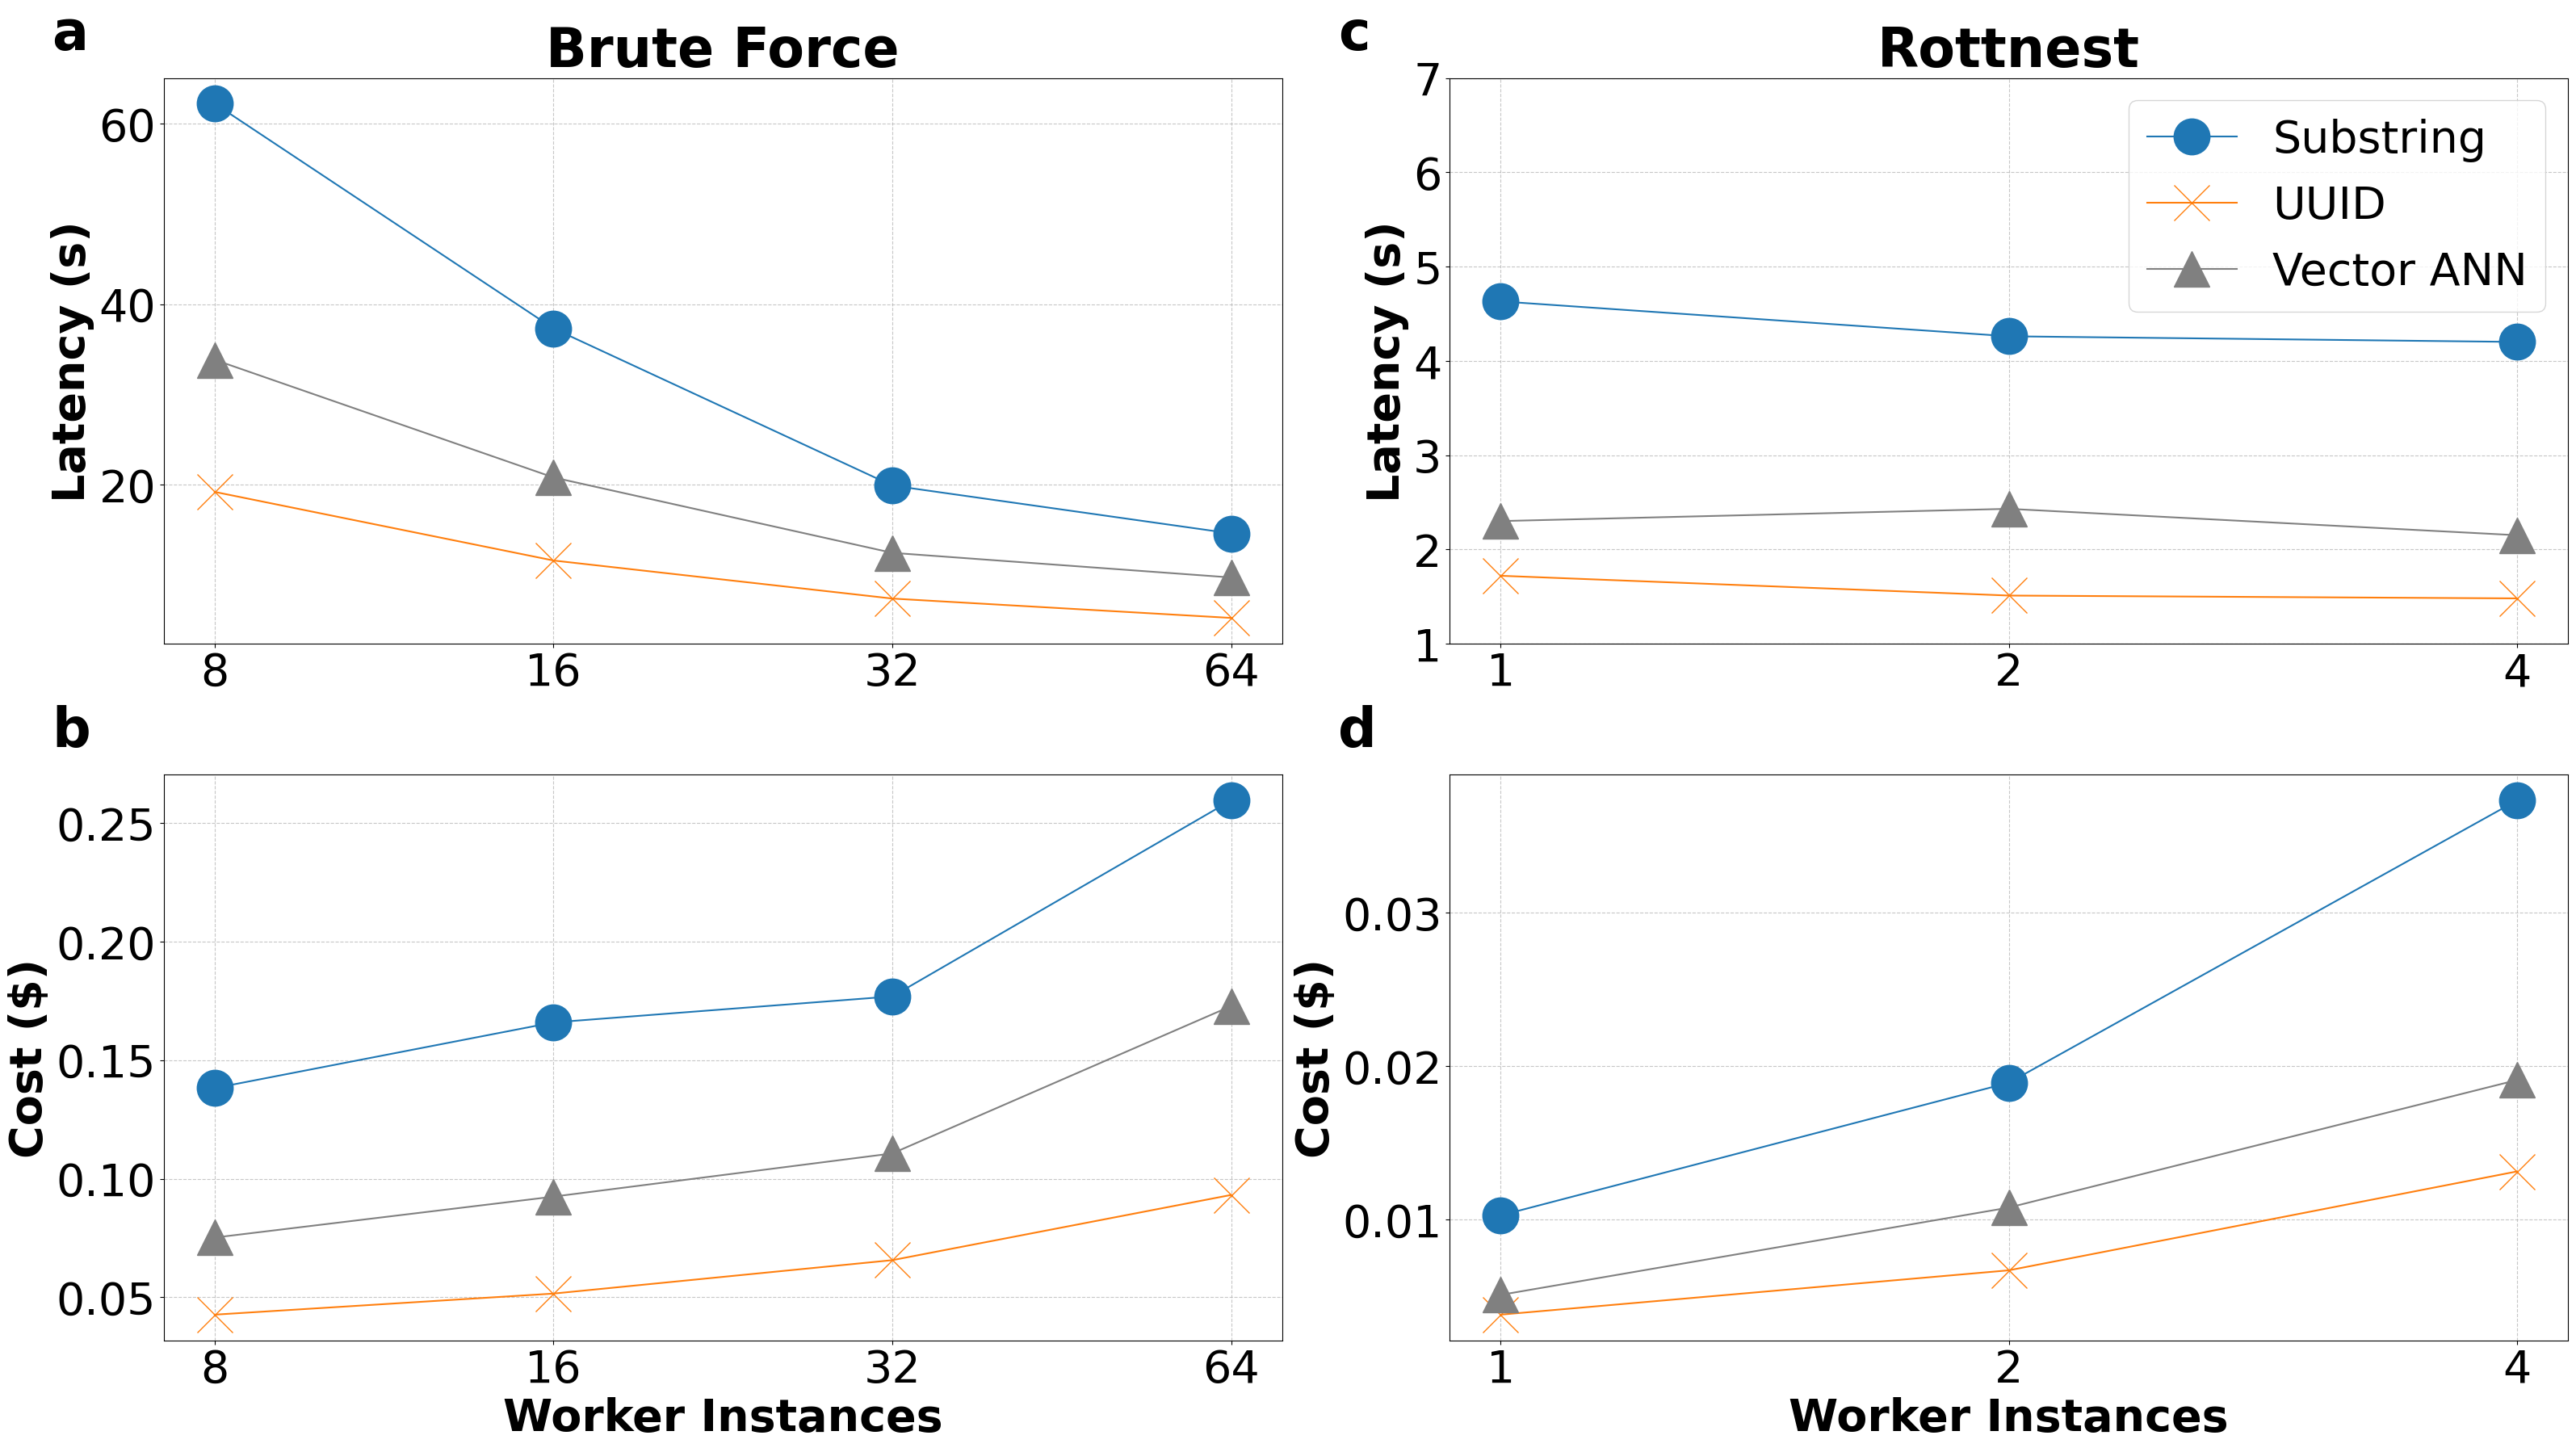

In [53]:
import matplotlib.pyplot as plt
import numpy as np

FONTSIZE = 40

def do_plot(ax,substring, uuid, vector) :
    ind = np.arange(len(substring))

    p1 = ax.plot(ind, substring, marker='o', markersize=32, label='Substring')
    p3 = ax.plot(ind, uuid, marker='x', markersize=32, label='UUID')
    pz = ax.plot(ind, vector, marker='^', markersize=32, label='Vector ANN', color='grey')
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(ind)

substring = [62.2, 37.3, 19.9, 14.6]
uuid = [19.2, 11.6, 7.385630992, 5.24]
vector = [33.83, 20.8, 12.45, 9.72]
ind = np.arange(len(substring))

fig, axs = plt.subplots(2,2, figsize=(32,18))

ax = axs[0,0]
# Line plots with markers

ax.set_title('Brute Force',  fontsize = 48, fontweight='bold')
do_plot(ax,substring, uuid, vector)
ax.set_ylabel('Latency (s)', fontsize=FONTSIZE, fontweight='bold')
ax.set_xticklabels(['8', '16', '32', '64'], fontsize=40)

# label ax with a
ax.text(-0.1, 1.05, "a", transform=ax.transAxes, fontsize=48, fontweight='bold')

substring = [0.1382222222, 0.1659111111, 0.1768888889, 0.2595555556]
uuid = [0.04266666667, 0.05155555556, 0.06565005326, 0.09315555556]
vector = [0.07517777778,0.09244444444,0.1106666667,0.1728]

ax = axs[1,0]

do_plot(ax,substring, uuid, vector)

ax.set_xticklabels(['8', '16', '32', '64'], fontsize=40)
ax.set_ylabel('Cost ($)', fontsize=FONTSIZE, fontweight='bold')
ax.set_xlabel('Worker Instances', fontsize=FONTSIZE, fontweight='bold')

# label ax with b
ax.text(-0.1, 1.05, "b", transform=ax.transAxes, fontsize=48, fontweight='bold')

substring = [4.63, 4.26, 4.2]
uuid = [1.72,1.51, 1.48]
vector = [2.3, 2.43, 2.15]

ind = np.arange(len(substring))
width = 0.15  # the width of the bars: can also be len(x) sequence

ax = axs[0,1]

ax.set_title('Rottnest', fontsize = 48, fontweight='bold')
do_plot(ax,substring, uuid, vector)

ax.set_xticklabels(['1', '2', '4'], fontsize=40)
ax.set_ylabel('Latency (s)', fontsize=FONTSIZE, fontweight='bold')
ax.legend(fontsize=FONTSIZE)

ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax.set_ylim(1,7)

# label ax with a
ax.text(-0.1, 1.05, "c", transform=ax.transAxes, fontsize=48, fontweight='bold')

substring = [0.01028888889, 0.01893333333, 0.03733333333]
uuid = [0.003822222222,0.006711111111,0.01315555556]
vector = [0.005111111111,0.0108,	0.01911111111]

ind = np.arange(len(substring))
width = 0.15  # the width of the bars: can also be len(x) sequence

ax = axs[1,1]
do_plot(ax,substring, uuid, vector)
ax.set_ylabel('Cost ($)', fontsize=FONTSIZE, fontweight='bold')
ax.set_xlabel('Worker Instances', fontsize=FONTSIZE, fontweight='bold')
# Line plots with markers is efficient
ax.set_xticklabels(['1', '2', '4'], fontsize=40)

# label ax with a
ax.text(-0.1, 1.05, "d", transform=ax.transAxes, fontsize=48, fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("scale.pdf")
plt.show()


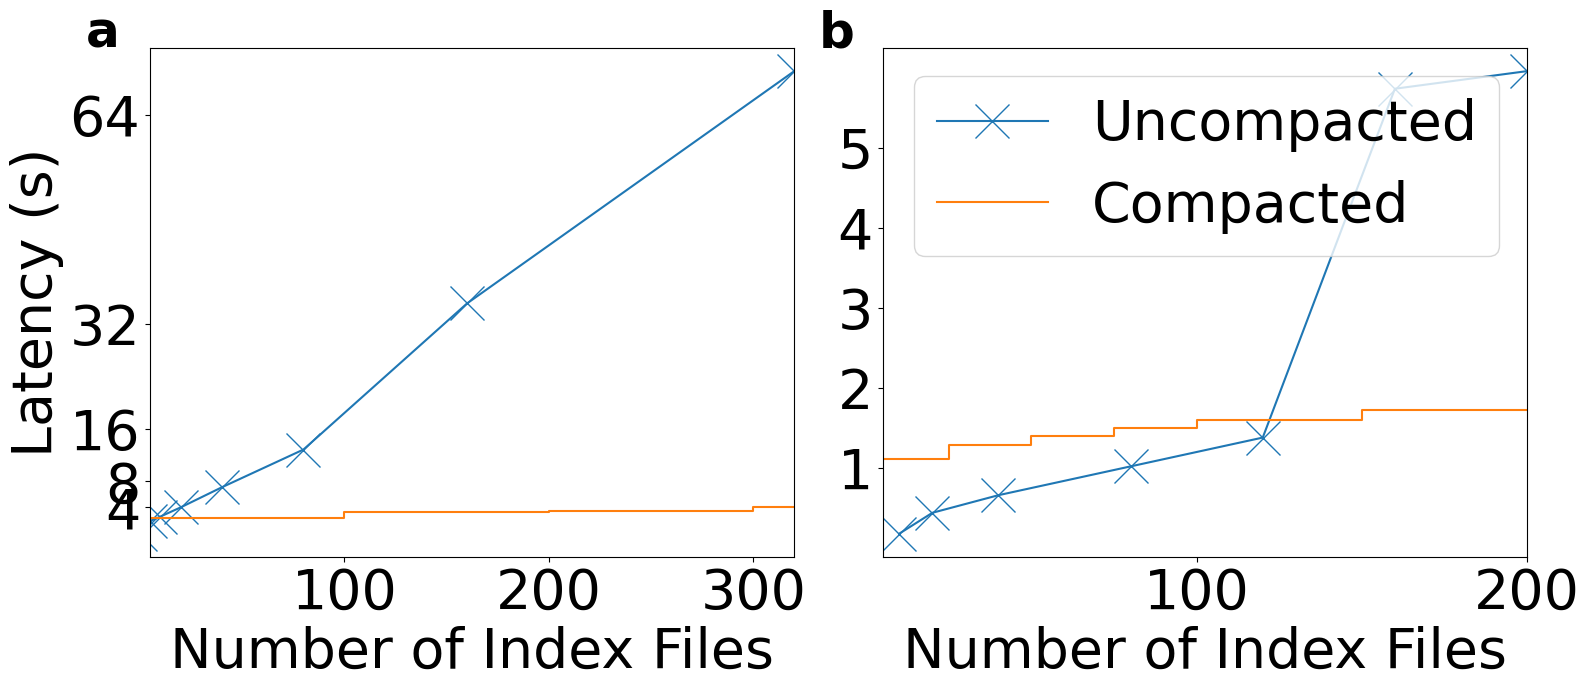

In [35]:
import matplotlib.pyplot as plt
import numpy as np

files = [0, 5, 10, 20, 40, 80, 160, 320]
latencies = [0, 1.9, 2.6, 4.014422392, 7.07, 12.86, 35.22270053, 70.77]

files2 = [0, 100, 100, 200, 200, 300, 300, 320]	
latencies2 = [2.43, 2.43, 3.3, 3.3, 3.5, 3.5, 4.1, 4.1]

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

ax = axs[0]
ax.plot(files, latencies, label="Uncompacted", marker='x', markersize=24)
ax.step(files2, latencies2, label="Compacted", where='post')

# ax.set_yscale("log")
ax.set_xlim(5, 320)
ax.set_ylabel('Latency (s)', fontsize=40)
ax.set_xlabel('Number of Index Files', fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=40)

# Get current y-ticks and add more tick locations
current_yticks = ax.get_yticks()
new_yticks = np.concatenate([[4,8,16,32,64]])
new_yticks = np.sort(new_yticks)
new_yticks = new_yticks[(new_yticks >= ax.get_ylim()[0]) & (new_yticks <= ax.get_ylim()[1])]

ax.set_yticks(new_yticks)
ax.set_yticklabels([f'{x:.0f}' if x < 10 else f'{x:.0f}' for x in new_yticks])
ax.text(-0.1, 1, "a", transform=ax.transAxes, fontsize=36, fontweight='bold')

files = [10, 20, 40, 80, 120, 160, 200]
latencies = [0.18, 0.44, 0.66, 1.02, 1.38, 5.74, 5.96]

files2 = [0, 25, 25, 50, 50, 75, 75, 100, 100, 150, 150, 200]
latencies2 = [1.11, 1.11, 1.29, 1.29, 1.40, 1.40, 1.50, 1.50,1.6, 1.6, 1.72, 1.72]

ax = axs[1]
ax.plot(files, latencies, label="Uncompacted", marker='x', markersize=24)
ax.step(files2, latencies2, label="Compacted", where='post')

# ax.set_yscale("log")
ax.set_xlim(5, 200)
ax.set_xlabel('Number of Index Files', fontsize=40)
ax.legend(fontsize=40, loc="upper right")
ax.tick_params(axis='both', which='major', labelsize=40)

# Get current y-ticks and add more tick locations
current_yticks = ax.get_yticks()
new_yticks = np.concatenate([[1,2,3,4,5]])
new_yticks = np.sort(new_yticks)
new_yticks = new_yticks[(new_yticks >= ax.get_ylim()[0]) & (new_yticks <= ax.get_ylim()[1])]

ax.set_yticks(new_yticks)
ax.set_yticklabels([f'{x:.0f}' if x < 10 else f'{x:.0f}' for x in new_yticks])
ax.text(-0.1, 1, "b", transform=ax.transAxes, fontsize=36, fontweight='bold')


plt.tight_layout()
plt.savefig("size_scaling.pdf")
plt.show()
